In [2]:
import copy
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize
import skimage.data
import skimage.filters
import skimage.transform

# TODO: figure out a better way of doing this
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
# import register
import utils

im = skimage.data.astronaut()
im = np.uint8(255 * skimage.transform.resize(im, (200, 200)))

PADDED_IM_SIZE = (400, 400) 

/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


grad: [0.5376255416465129, 0.5223857826754515, 0.5210782545857378, 0.5042107866479089, 0.521777293392946, 0.5217866724494677]
scale_x: 1.00, scale_y: 1.00, rotation: 0.10, shear: 0.00, t_x: 0.00, t_y: 0.00, SSD: 0.052
scale_x: 0.57, scale_y: 0.59, rotation: -0.31, shear: -0.40, t_x: -0.41, t_y: -0.41, SSD: 0.064
grad: [0.6353740054259852, 0.6357465484771525, 0.6450548975907086, 0.6378400877405018, 0.644686221804497, 0.6446875076008363]
scale_x: 0.92, scale_y: 0.92, rotation: 0.02, shear: -0.08, t_x: -0.08, t_y: -0.08, SSD: 0.051
grad: [0.513487336177998, 0.5063861654608364, 0.506996813333787, 0.4883682124713358, 0.5063679699724143, 0.5063710228449667]
scale_x: 0.69, scale_y: 0.70, rotation: -0.20, shear: -0.29, t_x: -0.30, t_y: -0.30, SSD: 0.056
grad: [0.5548967099610163, 0.5581901589207591, 0.5643214070998569, 0.5543759950916516, 0.5642496210208271, 0.5642539145255862]
scale_x: 0.87, scale_y: 0.88, rotation: -0.02, shear: -0.12, t_x: -0.12, t_y: -0.12, SSD: 0.051
grad: [0.509841754069

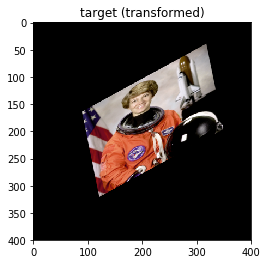

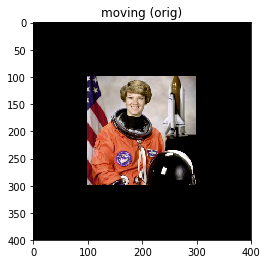

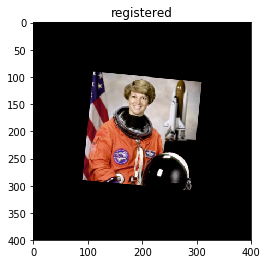

In [5]:

def apply_affine_tform(params, im):
    scale_x, scale_y, rotation, shear, trans_x, trans_y = params
    
    # re-initialize bad scales
    if scale_x < 0:
        scale_x = [np.abs(np.random.randn())]
        print(scale_x)
    if scale_x < 0:
        scale_x = [np.abs(np.random.randn())]
        print(scale_x)

    moving_tfm = skimage.transform.AffineTransform(
        scale=(scale_x, scale_y),
        rotation=rotation,
        shear=shear,
        translation=(trans_x, trans_y))

    return utils.apply_matrix_tform(im, moving_tfm)
    
def ssd_affine(params, im_fixed, im_moving,
               show_figs=False, mask_moving=None):
    """SSD is calculated between im_fixed and transformed moving image.

    TODO (nripesh): calculate gradient (numeric or mathematical)
    TODO : callbacks to view progress as images?
    TODO: how to calculate scale - is it simply based on the 
          ratio of the range of params?
    TODO: parallelize the derivative calculation
    """
    # get individual params
    im_moving_regis = apply_affine_tform(params, im_moving)
    row, col, channel = im_moving_regis.shape
    
    if mask_moving is None:
        ssd = np.sum(np.square(im_fixed - im_moving_regis)) / (
            row * col * channel)
    else:
        im_moving_regis = np.multiply(im_moving_regis, mask_moving)
        ssd = np.sum(np.square(im_fixed - im_moving_regis)) / (
            row * col * channel)

        
        
    scale_x, scale_y, rotation, shear, trans_x, trans_y = params
    print('scale_x: {:2.2f}, scale_y: {:2.2f}, rotation: {:2.2f}, '.format(
        scale_x, scale_y, rotation) +
          'shear: {:2.2f}, t_x: {:2.2f}, t_y: {:2.2f}, SSD: {:2.3f}'.format(
        shear, trans_x, trans_y, ssd))
    
    if show_figs:
        plt.figure(1)
        plt.title('target (transformed)')
        plt.imshow(im_fixed)
        plt.figure(2)
        plt.title('moving (orig)')
        plt.imshow(im_moving)
        plt.figure(3)
        plt.title('registered')
        plt.imshow(im_moving_regis)
        plt.show()

    return ssd

def gradient_affine(params, im_fixed, im_moving,
             show_figs=False, delta=.1, scale=[1]):
    
    if len(scale) == 1:
        scale = scale * len(params)
        
    row, col, channel = im_fixed.shape
        
    grad = []
    for i in range(len(params)):
        params_i = copy.deepcopy(params)
        params_i[i] += delta * scale[i]
        
        im_moving_regis_i = apply_affine_tform(params_i, im_moving)
        ssd_i = np.sum(np.square(im_fixed - im_moving_regis_i)) / (
            row * col * channel)
        grad.append(ssd_i / delta)
        
    print('grad: {}'.format(grad))
    return grad

def im_register_affine(im_fixed, im_moving, pad_size=None,
                       options={}, show_figs=False, 
                       delta=.1, scale=[1]):
    """For registering using affine transformation.
    """
    if pad_size is None:
        pad_size = (int(im_moving.shape[0] * 2),
                    int(im_moving.shape[1] * 2))

    orig_size = (im_moving.shape[0], im_moving.shape[1])

    im_fixed = utils.resize_image(im_fixed, pad_size)
    im_moving = utils.resize_image(im_moving, pad_size) / 255
    
    moving_mask = im_moving > 0
    
    im_f_shape = im_fixed.shape
    im_m_shape = im_moving.shape

    assert im_f_shape == im_m_shape

    # random initialization and assignment
    init_scale = (1., 1.)
    init_rotation = .1
    init_shear = 0.0
    init_translation = (0, 0)
    params_init = (init_scale[0], init_scale[1], init_rotation,
                   init_shear, init_translation[0], init_translation[1])
    
    error_function = lambda x: ssd_affine(
        x, im_fixed, im_moving, show_figs=show_figs)
    
    error_gradient = lambda x: gradient_affine(
        x, im_fixed, im_moving, show_figs=show_figs,
        delta=delta, scale=scale)
    
    method = 'BFGS'
    
    if method == 'Nelder-Mead':
        affine_optimized = scipy.optimize.minimize(
            error_function, params_init, method='Nelder-Mead',
            options=options, jac='2-point')
    elif method == 'BFGS':
        affine_optimized = scipy.optimize.minimize(
            error_function, params_init, method='BFGS',
            options=options, jac=error_gradient)
    
    # apply solved registration
    regis_tfm = skimage.transform.AffineTransform(
        scale=(affine_optimized.x[0], affine_optimized.x[1]),
        rotation=affine_optimized.x[2],
        shear=affine_optimized.x[3],
        translation=(affine_optimized.x[4], affine_optimized.x[5]))
    
    im_registered = utils.apply_matrix_tform(
            im_moving, regis_tfm)

    return utils.resize_image(im_registered, orig_size), regis_tfm

# initialization
true_scale = (1.3, .8)
true_rotation = -.5
true_shear = .3
true_translation = (20, -20)
# true_translation = (0, 0)


aff_tfm = skimage.transform.AffineTransform(
    scale=true_scale,
    rotation=true_rotation,
    shear=true_shear,
    translation=true_translation)

im_fixed = utils.apply_matrix_tform(
    utils.resize_image(im, PADDED_IM_SIZE), aff_tfm)
im_moving = utils.resize_image(im, PADDED_IM_SIZE)

# save images
plt.imsave('../astronout_orig.png', im_moving)
plt.imsave('../astronout_morphed.png', im_fixed)

# optimization

# scaling based on maximum parameter values
scale = [3, 3, 2*3.14, 1, 100, 100]
scale = [1/3, 1/3, 1 / (2 * 3.14), 1, .01, .01]

delta = .1
blur_images = False
    
im_registered, regis_tfm = im_register_affine(
    im_fixed, im_moving, pad_size=PADDED_IM_SIZE,
    options={'maxiter': 200}, show_figs=False,
    delta=delta, scale=scale
)


plt.figure(1)
plt.title('target (transformed)')
plt.imshow(im_fixed)
plt.figure(2)
plt.title('moving (orig)')
plt.imshow(im_moving)
plt.figure(3)
plt.title('registered')
plt.imshow(im_registered)
plt.show()

In [76]:
aff_tfm.params, regis_tfm.params

(array([[  1.14085733,   0.15893546,  20.        ],
        [ -0.6232532 ,   0.78405326, -20.        ],
        [  0.        ,   0.        ,   1.        ]]),
 array([[  1.14085711,   0.15893534,  19.99999298],
        [ -0.623253  ,   0.78405332, -19.99999375],
        [  0.        ,   0.        ,   1.        ]]))